In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.model_selection import cross_val_score

# Data Application

The data in this examples comes originally from a study by Stamey et al (1989) that examined the correlation between the level of prostate specific antigen (PSA) and several number of clinical measures for 97 men who were about to receive prostatectomy.

The goal of the exercise is to predict the log of PSA from a number of measurements including log cancer volume (lcavol), log prostate weight lweight, age, log of benign prostatic hyperplasia amount lbph, seminal vesicle invasion svi, log of capsular penetration lcp, Gleason score gleason, and percent of Gleason scores 4 or 5 pgg45.

In [2]:
raw_data = pd.read_csv('prostate_dataset.txt', delimiter='\t')

In [10]:
raw_data

,col,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [11]:
raw_data.shape

(97, 11)

In [12]:
raw_data.isnull().sum()

col        0
lcavol     0
lweight    0
age        0
lbph       0
svi        0
lcp        0
gleason    0
pgg45      0
lpsa       0
train      0
dtype: int64

In [13]:
raw_data.iloc[:,1:-1].describe().round(2)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00,97.00
mean,1.35,3.63,63.87,0.10,0.22,-0.18,6.75,24.38,2.48
std,1.18,0.43,7.45,1.45,0.41,1.40,0.72,28.20,1.15
min,-1.35,2.37,41.00,-1.39,0.00,-1.39,6.00,0.00,-0.43
25%,0.51,3.38,60.00,-1.39,0.00,-1.39,6.00,0.00,1.73
50%,1.45,3.62,65.00,0.30,0.00,-0.80,7.00,15.00,2.59
75%,2.13,3.88,68.00,1.56,0.00,1.18,7.00,40.00,3.06
max,3.82,4.78,79.00,2.33,1.00,2.90,9.00,100.00,5.58


In [3]:
X = raw_data.iloc[:,1:-2]
y = raw_data.iloc[:,9]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns = X.columns)

In [4]:
#X_train = raw_data.iloc[:,1:-2][raw_data['train']=='T'] #not scaled
X_train = X_scaled[raw_data['train']=='T']
y_train = raw_data.iloc[:,9][raw_data['train']=='T']
#X_test = raw_data.iloc[:,1:-2][raw_data['train']=='F'] #not scaled
X_test = X_scaled[raw_data['train']=='F']
y_test = raw_data.iloc[:,9][raw_data['train']=='F']

In [5]:
X_train.shape
X_test.shape

(30, 8)

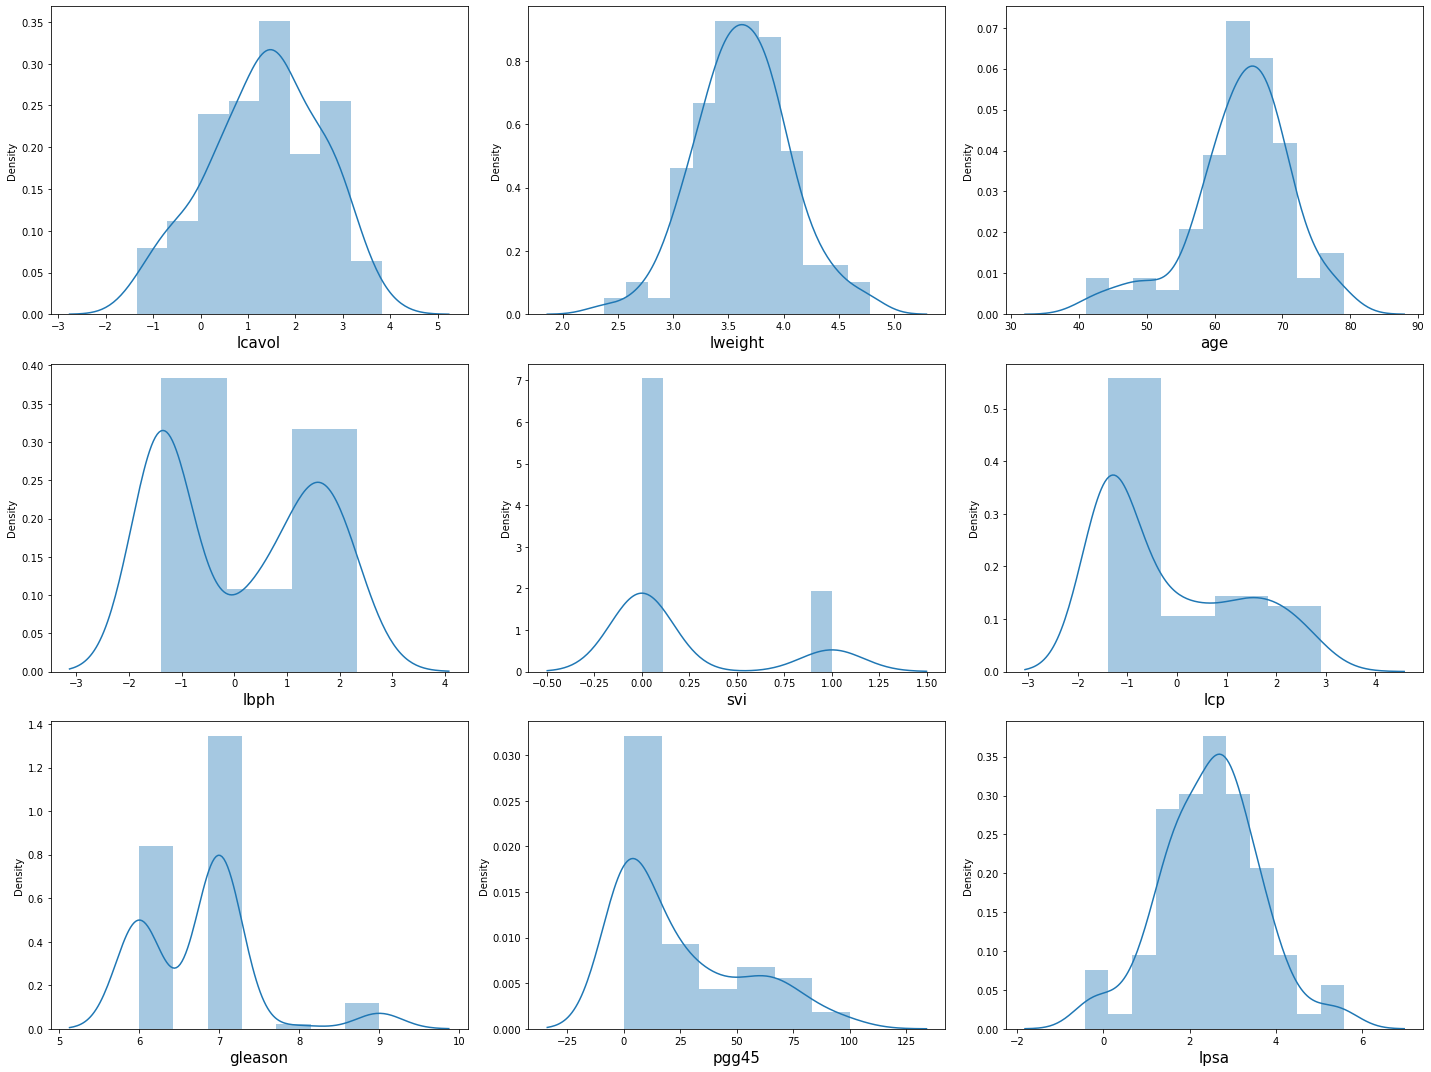

In [6]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for column in raw_data.iloc[:,1:-1]:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(raw_data.iloc[:,1:-1][column])
        plt.xlabel(column, fontsize = 15)
        
    plotnumber += 1
    
plt.tight_layout()
plt.show()

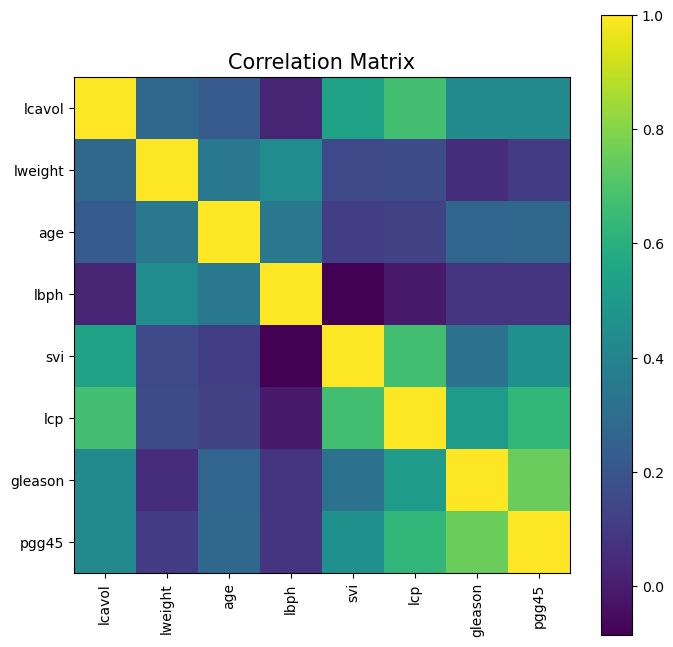

In [7]:
# Correlation matrix
def correlation_matrix(data):
    corr = data.corr()
    plt.figure(figsize=(8,8), dpi=100)
    corr_mat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corr_mat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()
correlation_matrix(X_scaled)

#from the plot below we can see that
#-->there is some correlation among regressors. E.g. gleason and pgg45 are correlated, indeed, the variable pgg45 measures the percentage of 4 or 5 Gleason scores that were recorded before the final current Gleason score

Below: Replication of scatterplot matrix of the prostate cancer in Elements of Statistical Learning, pg. 3. The predictors svi and gleason are categorical. 

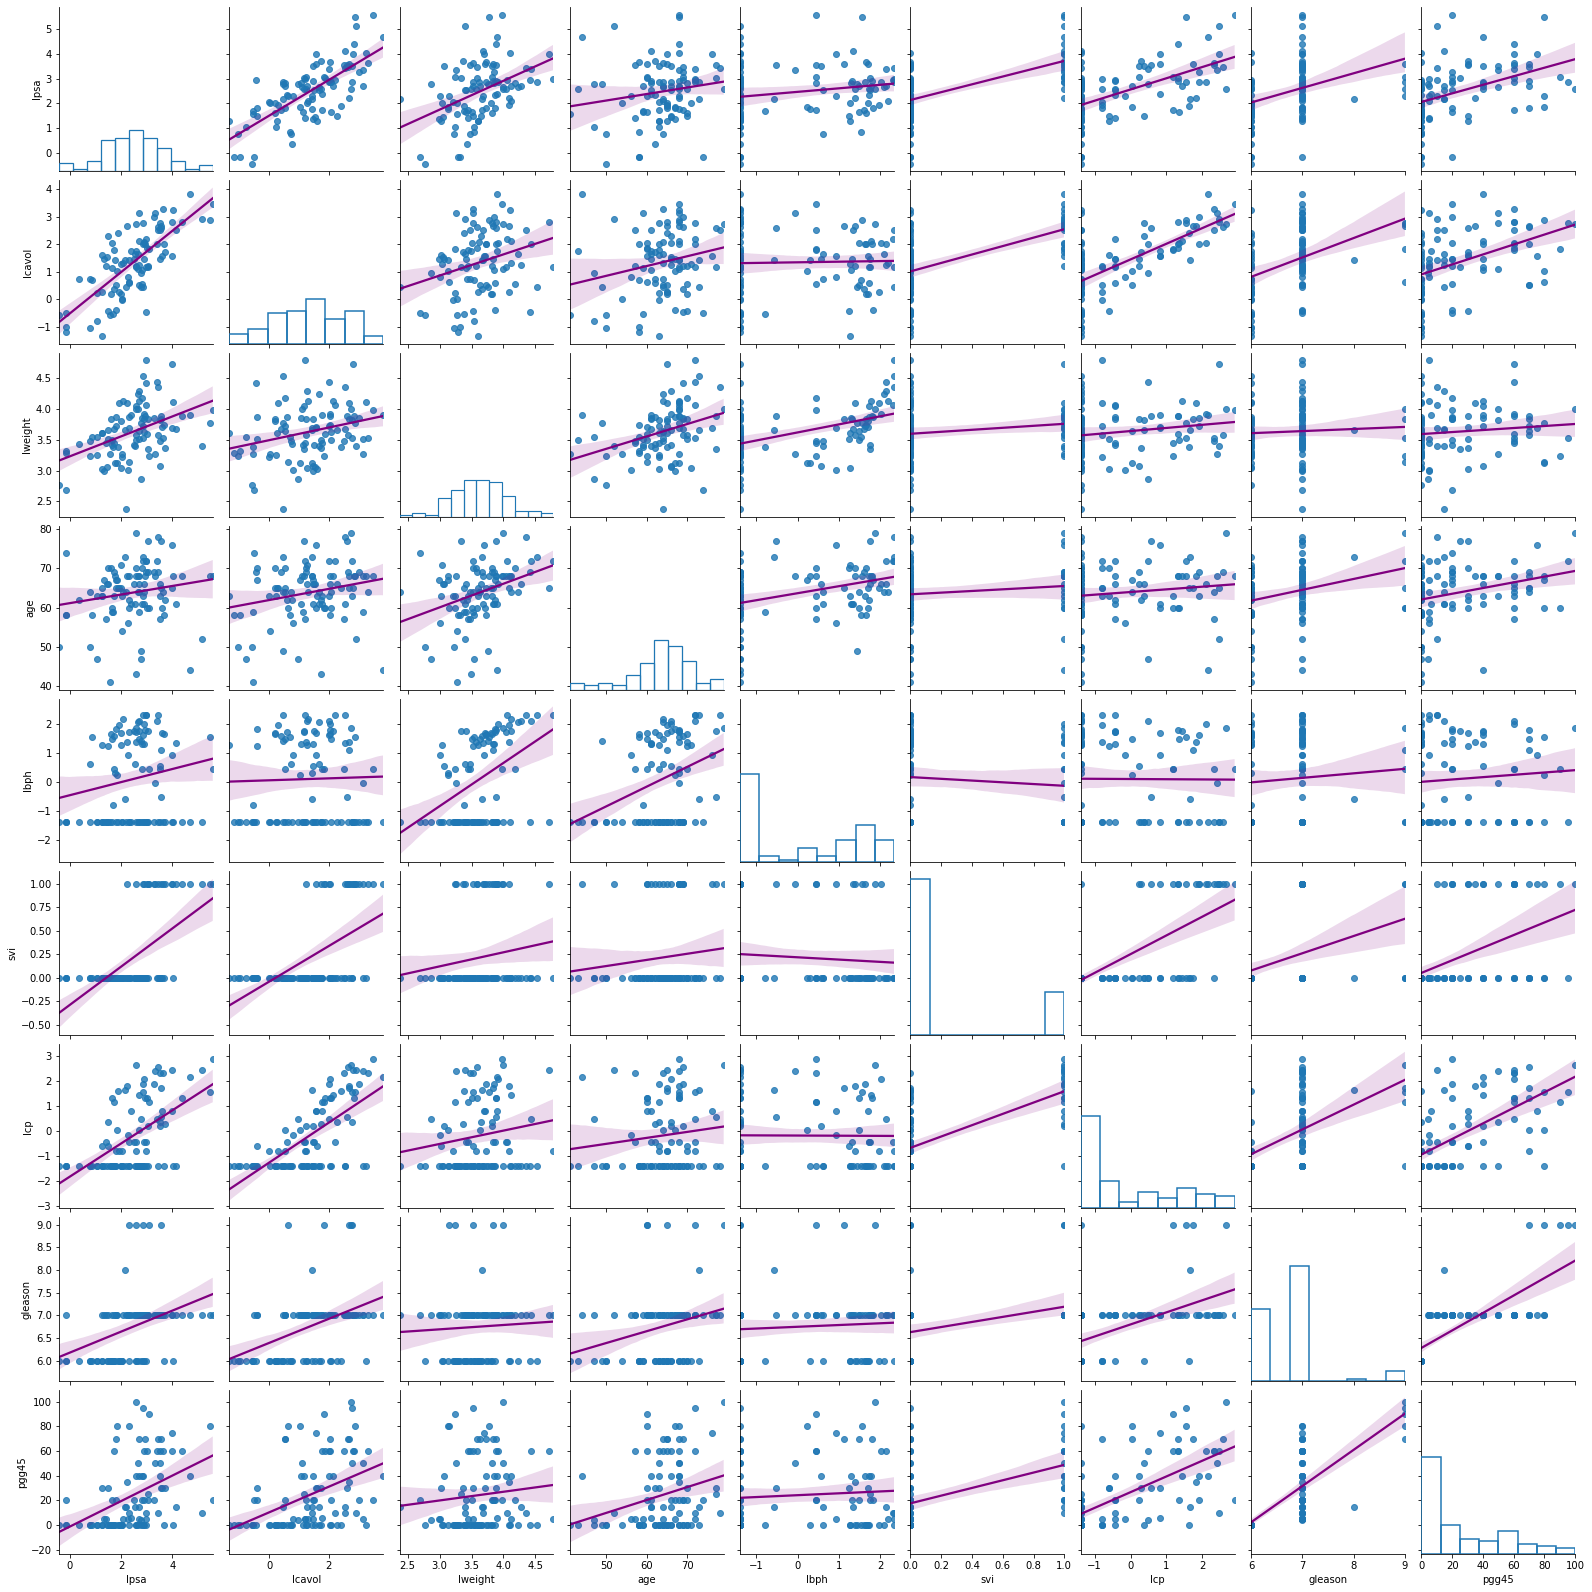

In [10]:
sns.pairplot(
    data=raw_data[['lpsa','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']],
    #plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False),
    kind="reg", 
    plot_kws={'line_kws':{'color':'purple'}}
)

In [10]:
corr = raw_data[['lpsa','lcavol','lweight','age','lbph','svi','lcp','gleason','pgg45']].corr()
corr.style.background_gradient(cmap='coolwarm')

,lpsa,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lpsa,1.000000,0.734460,0.433319,0.169593,0.179809,0.566218,0.548813,0.368987,0.422316
lcavol,0.734460,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652
lweight,0.433319,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354
age,0.169593,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.179809,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.566218,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.548813,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.368987,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.422316,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


Variables that show strong correlation (not against lpsa):
- lcp and lcavol
- svi and lcp
- pgg45 and gleason
- pgg45 and lcp

# Linear regression baseline

In [6]:
# Linear regression model
lr = linear_model.LinearRegression()
# learn the model on the train set
lm_reg=lr.fit(X_train,y_train)
# baseline error
y_pred = lr.predict(X_test)
baseline_error = np.mean((y_pred - y_test) ** 2)
print("Linear regression error: %0.4f" % baseline_error)

Linear regression error: 0.5213


In [14]:
def table_coefficients(coefficients, round_param):
    names = ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45"]
    values = coefficients.round(round_param)
    list_of_tuples = list(zip(names, values))
    table = pd.DataFrame(list_of_tuples, columns = ['Term', 'Coefficient'])
    return table

Coefficients of the regression (the same as in ESL, pg.50)

In [41]:
table_coefficients(lm_reg.coef_, 3)

,Term,Coefficient
0,lcavol,0.676
1,lweight,0.262
2,age,-0.141
3,lbph,0.209
4,svi,0.304
5,lcp,-0.287
6,gleason,-0.021
7,pgg45,0.266


In [31]:
def plot_model_coefficients(coefficients, reg_type):
    df_lm_coefficients = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'coef': coefficients.flatten()}
                      )

    fig, ax = plt.subplots(figsize=(11, 3.84))
    ax.stem(df_lm_coefficients.predictor, df_lm_coefficients.coef, markerfmt=' ')
    plt.xticks(rotation=90, ha='right', size=10)
    ax.set_xlabel('variable')
    ax.set_ylabel('coefficients')
    plt.title(f"{reg_type} model coefficients", fontsize = 15);

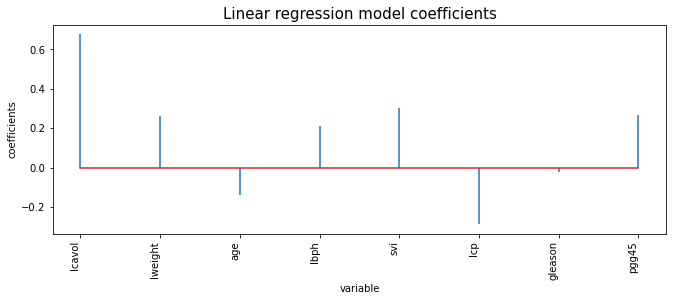

In [33]:
plot_model_coefficients(lm_reg.coef_, "Linear regression")

# Ridge regression

To avoid overfitting, ridge regression has a grouped selection effect: the correlated variables have the same weights.

In [60]:
#n_alphas = 100
#alphas = np.logspace(-4, 3, n_alphas)
n_alphas = 300
alphas = np.logspace(-6, 6, n_alphas)

coef_ridge = []
err_ridge = []
baseline = []
for a in alphas:
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    coef_ridge.append(ridge.coef_)
    y_pred = ridge.predict(X_test)
    ridge_error = np.mean((y_pred - y_test) ** 2)
    err_ridge.append(ridge_error)
    baseline.append(baseline_error)

In [61]:
ridge_cv = RidgeCV(alphas = alphas, cv = 10)
ridge_cv.fit(X_train, y_train)
alpha = ridge_cv.alpha_
alpha#is different from the minimum found below (?)##############
ridge = Ridge(alpha = alpha)
ridge.fit(X_train, y_train)
pred_err_ridge_cv = np.mean((ridge.predict(X_test) - y_test) ** 2)
print(ridge)
print(pred_err_ridge_cv)

Ridge(alpha=42.21026320156903)
0.5045813935527431


In [62]:
ridge_coef = ridge.coef_

In [63]:
ridge = Ridge()
grid = dict()
grid['alpha'] = alphas
gscv = GridSearchCV(ridge, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_train, y_train)
print(gscv.best_params_)
y_pred = gscv.predict(X_test)
pred_err_ridge_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_ridge_gs)

{'alpha': 2.4058630546440667}
0.5039812978160965


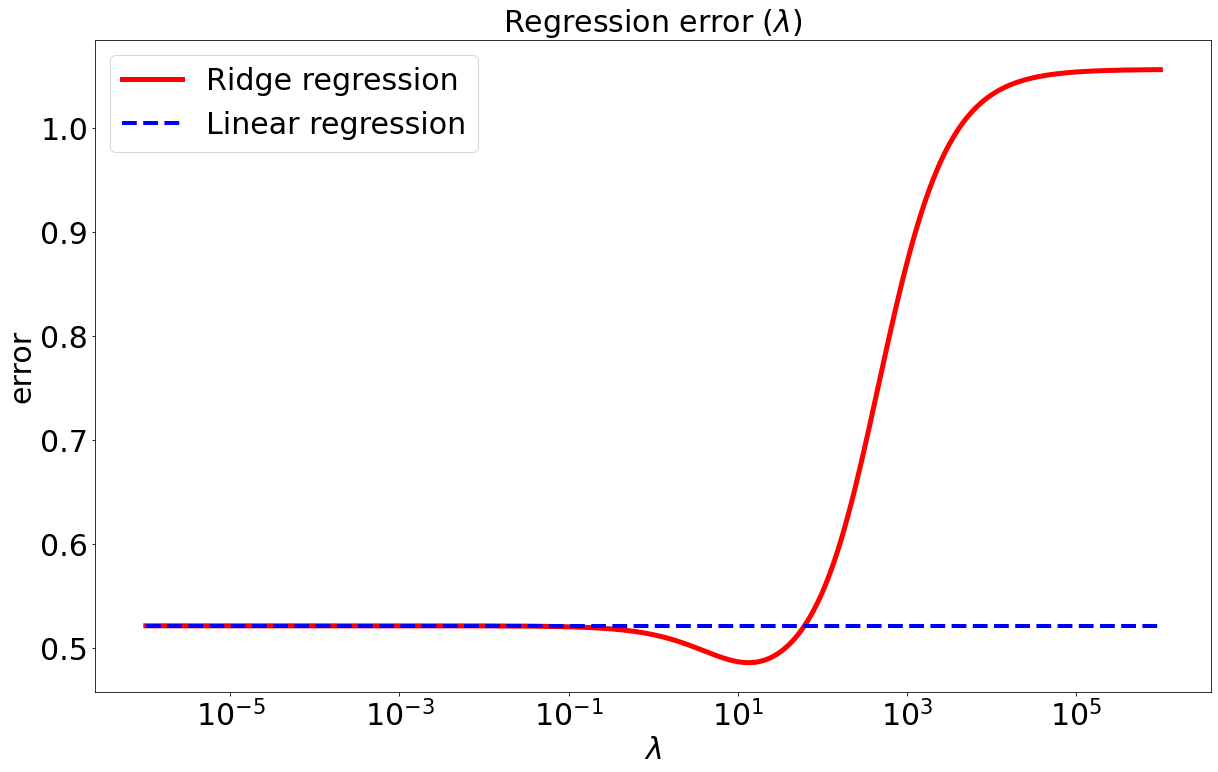

In [64]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, err_ridge, linewidth=5, color='red', label="Ridge regression")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [65]:
#min(err_ridge)

In [66]:
#alphas[np.argmin(err_ridge)]

In [67]:
###################################################################################

In [68]:
train_scores, val_scores = validation_curve(Ridge(),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

In [69]:
def plot_CV(val_scores, val_mean):
    plt.figure(figsize = (20,10))
    ax = plt.gca()
    ax.plot(alphas, val_scores, linewidth=1)
    ax.plot(alphas, val_mean, color="black", linewidth=5, label='Average across the folds')
    ax.axvline(alphas[np.argmin(val_mean)],0,6,linestyle='--',color="black", label='CV selected $\lambda$')
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("lambda", fontsize = 20)
    plt.ylabel("MSE", fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize = 20)
    plt.axis("tight")
    plt.title("MSE on each 10-fold Cross Validation ", fontsize = 28)
    plt.axis("tight")
    plt.legend()

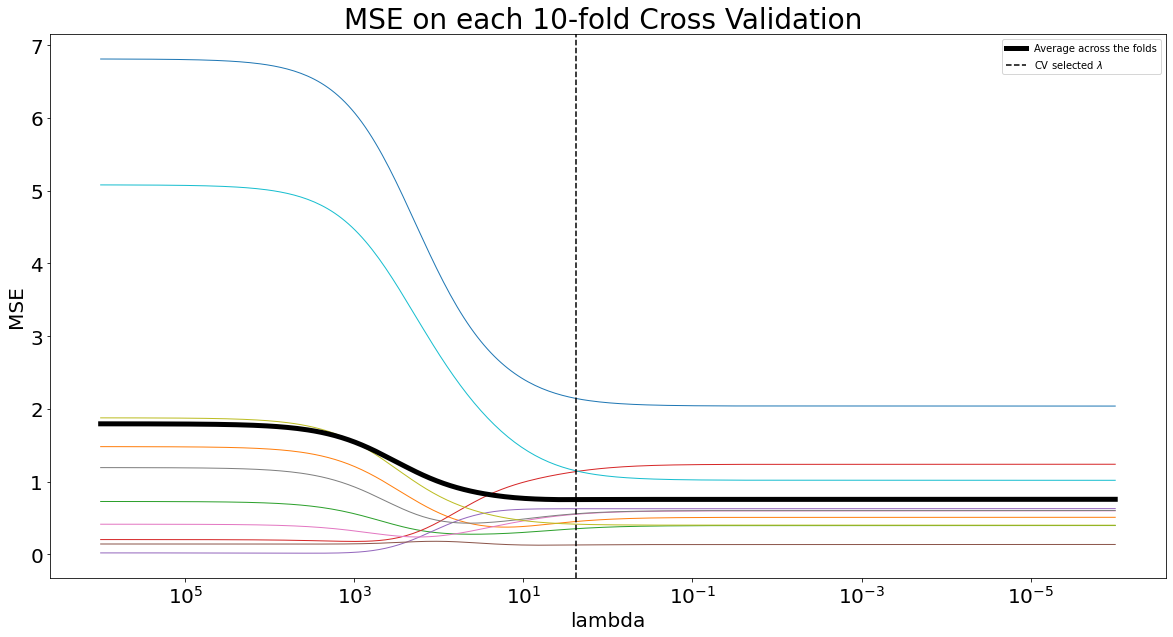

In [70]:
plot_CV(val_scores, val_mean)

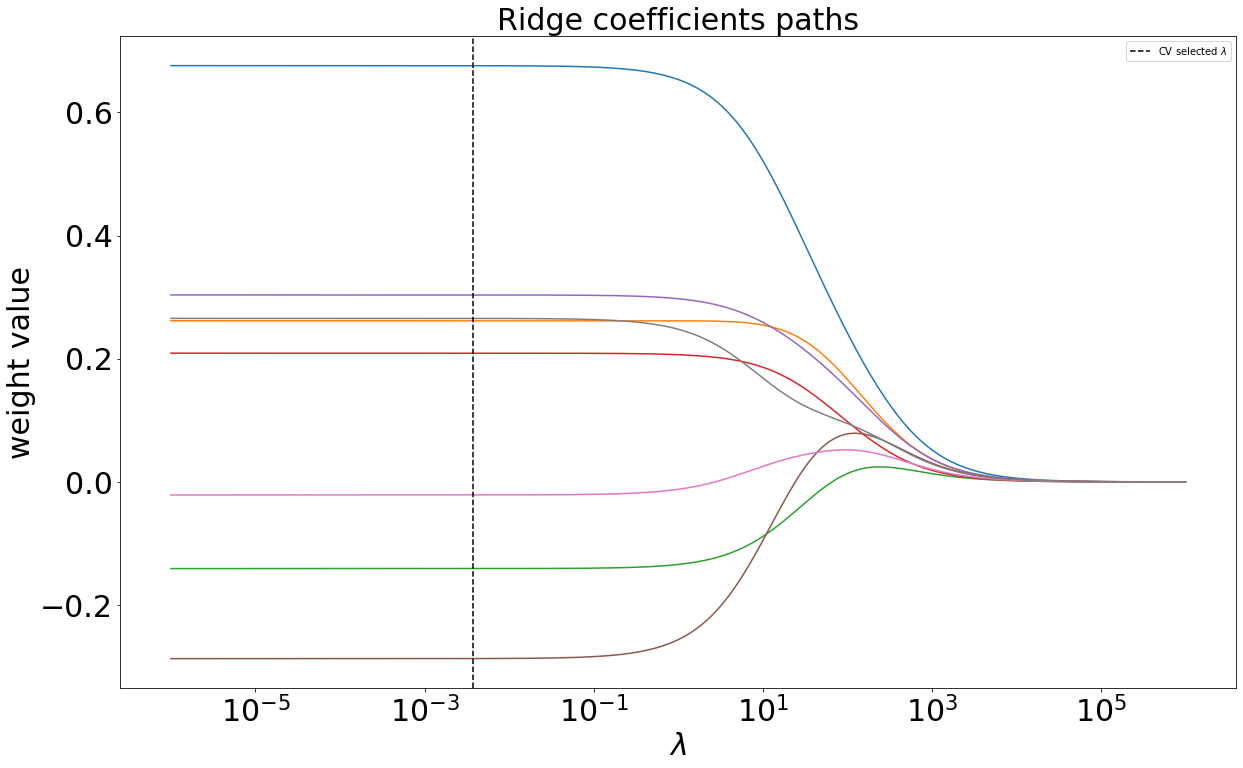

In [57]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_ridge)
ax.set_xscale('log')
ax.axvline(alphas[np.argmin(val_mean)],0,6,linestyle='--',color="black", label='CV selected $\lambda$')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Ridge coefficients paths', fontsize=30)
plt.legend()

In [18]:
table_coefficients(ridge_coef, 3)

,Term,Coefficient
0,lcavol,0.348
1,lweight,0.216
2,age,-0.020
3,lbph,0.139
4,svi,0.200
5,lcp,0.045
6,gleason,0.048
7,pgg45,0.115


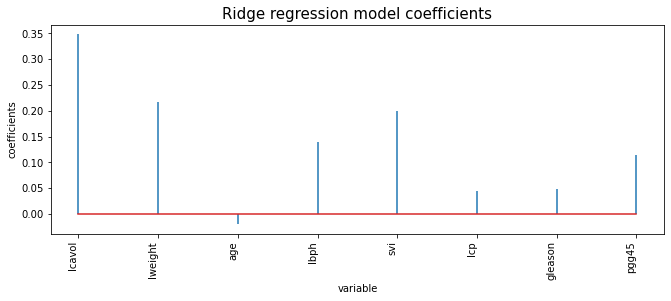

In [34]:
plot_model_coefficients(ridge_coef, "Ridge regression")

# Lasso regression

The Lasso performs a model's feature selection: for correlated variables, it retains only one variable and sets other correlated variables to zero. The counterpart is that it obviously induces a loss of information resulting in lower accuracy.

In [35]:
coef_lasso = []
err_lasso = []
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    coef_lasso.append(lasso.coef_)
    y_pred = lasso.predict(X_test)
    lasso_error = np.mean((y_pred - y_test) ** 2)
    err_lasso.append(lasso_error)

In [36]:
lasso_cv = LassoCV(alphas = alphas, cv = 10, max_iter = 10000)
lasso_cv.fit(X_train, y_train)
alpha = lasso_cv.alpha_
alpha#is different from the minimum found below (?)##############
lasso = Lasso(alpha = lasso_cv.alpha_)
lasso.fit(X_train, y_train)
pred_err_lasso_cv = np.mean((lasso.predict(X_test) - y_test) ** 2)
print(lasso)
print(pred_err_lasso_cv)

Lasso(alpha=0.0037316968377327556)
0.5107822709723145


In [37]:
train_scores, val_scores = validation_curve(Lasso(),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

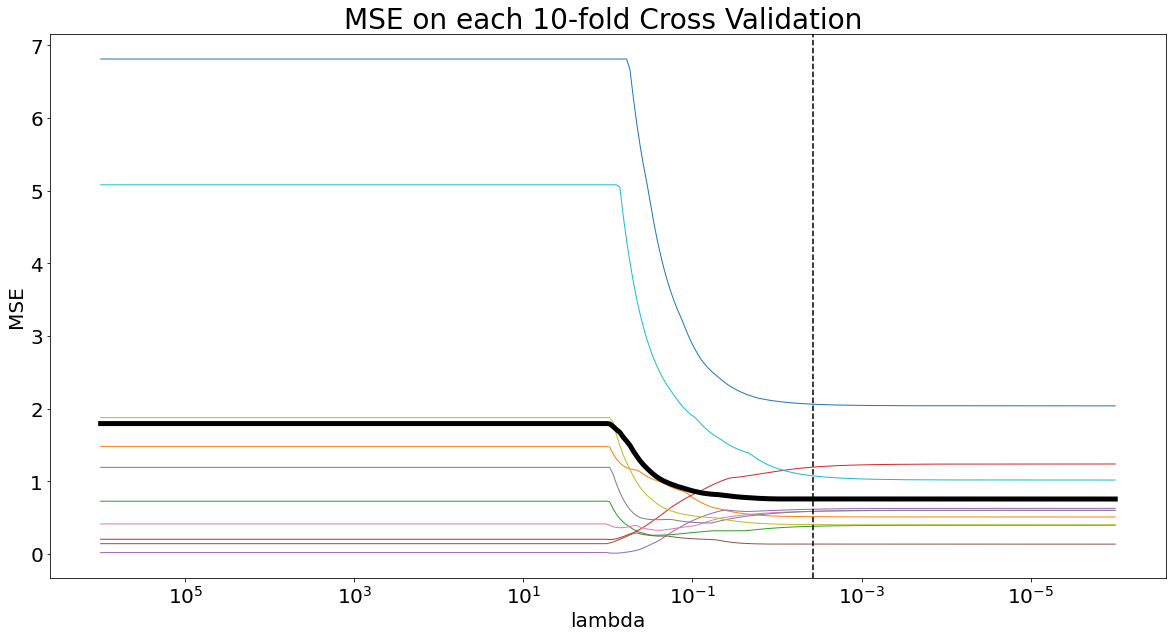

In [40]:
plot_CV(val_scores, val_mean)

In [41]:
alphas[np.argmin(val_mean)]

0.0037316968377327556

In [42]:
lasso = Lasso()
grid = dict()
grid['alpha'] = alphas
gscv = GridSearchCV(lasso, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_train, y_train)
print(gscv.best_params_)
y_pred = gscv.predict(X_test)
pred_err_lasso_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_lasso_gs)

{'alpha': 0.0037316968377327556}
0.5107822709723145


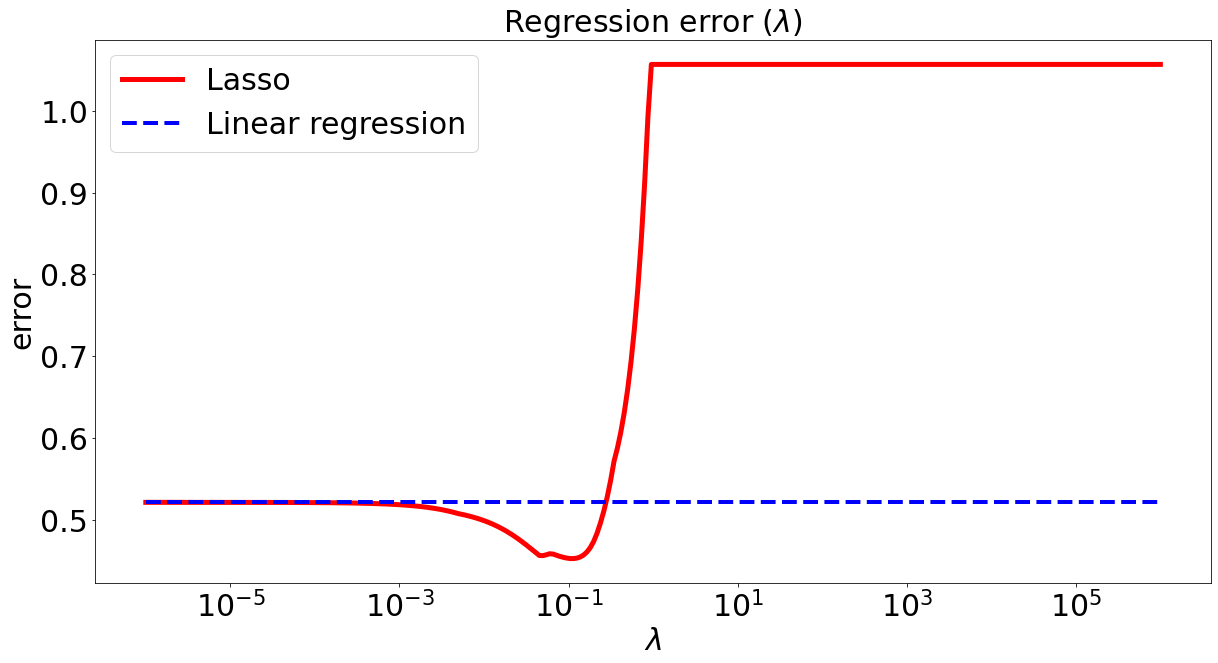

In [49]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_lasso, linewidth=5, color='red', label="Lasso")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($\lambda$)', fontsize=30)
plt.show()

In [41]:
min(err_lasso)

0.4524744740963335

In [42]:
alphas[np.argmin(err_lasso)]

0.10974987654930557

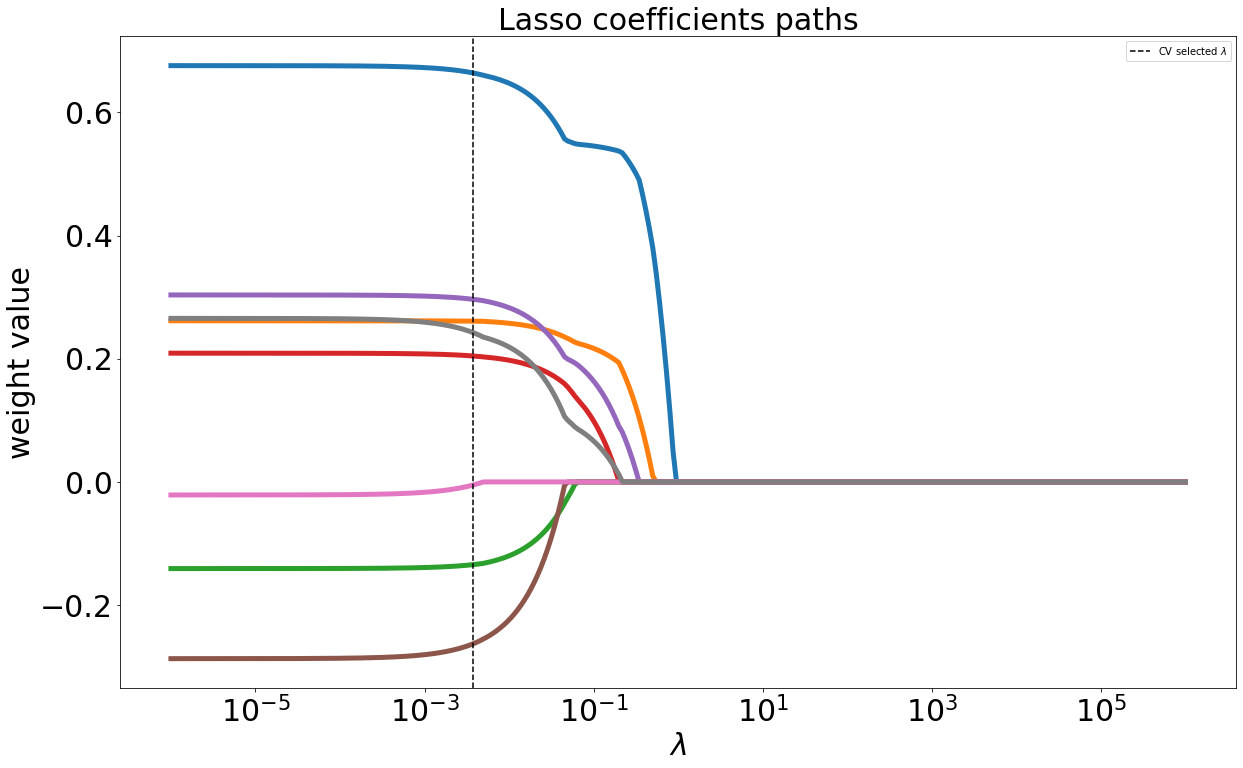

In [56]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_lasso, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
ax.axvline(alphas[np.argmin(val_mean)],0,6,linestyle='--',color="black", label='CV selected $\lambda$')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title('Lasso coefficients paths', fontsize=30)
plt.legend()

# Elastic Net regression

Elastic Net overcomes the issue of losing information. It has a selecting effect on variables as Lasso but keep correlated variables as Ridge regression. Thus the Elastic net model is less sparse than the Lasso, keeping more information.

In [48]:
coef_eln = []
err_eln = []
for a in alphas:
    elastic_net = ElasticNet(alpha = a, l1_ratio=0.5)
    elastic_net.fit(X_train, y_train)
    coef_eln.append(elastic_net.coef_)
    y_pred = elastic_net.predict(X_test)
    elasticnet_error = np.mean((y_pred - y_test) ** 2)
    err_eln.append(elasticnet_error)

In [95]:
ratios = np.linspace(0, 1, 40)
elnet_cv = ElasticNetCV(alphas = alphas, l1_ratio = ratios, cv = 10, max_iter = 100000)
elnet_cv.fit(X_train, y_train)
alpha = elnet_cv.alpha_
ratio = elnet_cv.l1_ratio_
alpha
ratio#is different from the minimum found BELOW (?)##############
elnet = ElasticNet(alpha = alpha, l1_ratio = ratio)
elnet.fit(X_train, y_train)
pred_err_elnet_cv = np.mean((elnet.predict(X_test) - y_test) ** 2)
print(elnet)
print(pred_err_elnet_cv)

ElasticNet(alpha=0.03789616980644716, l1_ratio=0.0)
0.5033040341050431


In [96]:
elnet = ElasticNet()
grid = dict()
grid['alpha'] = alphas
grid['l1_ratio'] = ratios
gscv = GridSearchCV(elnet, grid, scoring='neg_mean_squared_error', cv=10)
gscv.fit(X_train, y_train)
print(gscv.best_params_)
y_pred = gscv.predict(X_test)
pred_err_elnet_gs = np.mean((y_pred - y_test) ** 2)
print(pred_err_elnet_gs)

{'alpha': 0.03789616980644716, 'l1_ratio': 0.0}
0.5033040341050431


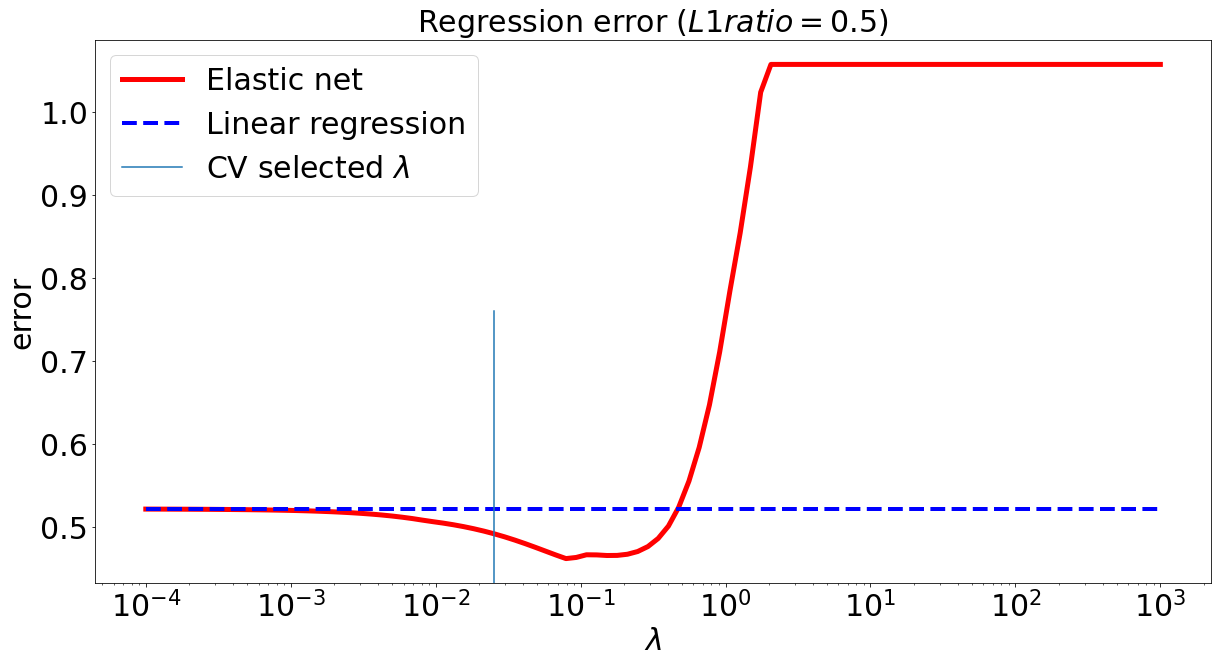

In [45]:
plt.figure(figsize=(20,10))
ax = plt.gca()
ax.plot(alphas, err_eln, linewidth=5, color='red', label="Elastic net")
ax.plot(alphas, baseline, linewidth=4,linestyle='--', color='blue', label='Linear regression')
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('error', fontsize=30)
ax.legend(fontsize=30)
plt.title(r'Regression error ($L1 ratio=0.5$)', fontsize=30)
plt.show()

In [13]:
min(err_eln)

0.461469717533694

In [15]:
alphas[np.argmin(err_eln)]

0.0792482898353917

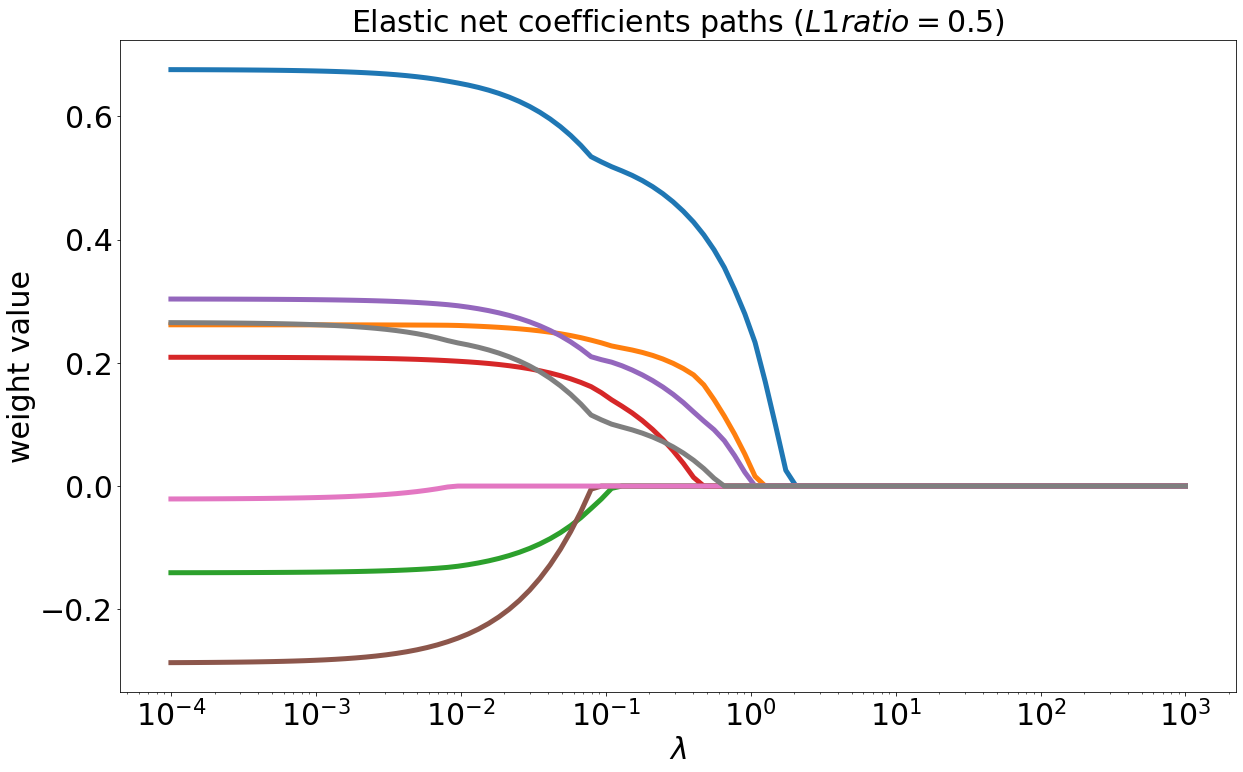

In [46]:
plt.figure(figsize=(20,12))
ax = plt.gca()
ax.plot(alphas, coef_eln, linewidth=5)
ax.set_xscale('log')
plt.xlabel('$\lambda$', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('weight value', fontsize=30)
plt.title(r'Elastic net coefficients paths ($L1 ratio=0.5$)', fontsize=30)
plt.show()

#as expected the Elastic net keeps more variables than the Lasso

In [ ]:
#THIS CHECK THAT THE MSE CURVE IS FLAT AFTER SOME THRESHOLD. sO THERE ARE SEVERAL ALPHAS THAT YIELDS THE SAME MSE.
#THEREFORE THE ELNET PLOT (TUNING L1_RATIO=0) SCENARIO WILL BE THE SAME AS RIDGE

train_scores, val_scores = validation_curve(ElasticNet(l1_ratio=0),
                                  X_train, y_train, param_name="alpha", param_range=alphas,
                                  cv=10, scoring='neg_mean_squared_error')
train_scores = -(train_scores)
val_scores = -(val_scores)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plot_CV(val_scores, val_mean)

# Model selection

In [114]:
print("Linear regression error:   %0.4f" % baseline_error)    
print("Minimun ridge error:       %0.4f" % min(err_ridge))
print("Minimum lasso error:       %0.4f" % min(err_lasso))
print("Minimum elastic net error: %0.4f" % min(err_eln))

#Lasso is more parsimonious but there is likely to be a loss of accuracy.
#Elastic net is a good trade-off for accuracy and computational cost balance between the Ridge regression and the Lasso.

Linear regression error:   0.5213
Minimun ridge error:       0.4859
Minimum lasso error:       0.4525
Minimum elastic net error: 0.4615


In [75]:
#using cross-validation (CV from sklearn.linear_model)
print("Linear regression test MSE:   %0.4f" % baseline_error)    
print("ridge test MSE:       %0.4f" % (pred_err_ridge_gs))
print("lasso test MSE:       %0.4f" % (pred_err_lasso_gs))
print("elastic net test MSE: %0.4f" % (pred_err_elnet_gs))

Linear regression test MSE:   0.5213
ridge test MSE:       0.5043
lasso test MSE:       0.5112
elastic net test MSE: 0.5043
